In [18]:
import pandas as pd
import numpy as np

# Configuration
n_schools = 30
n_students_per_school = 100  # 100 students per school
subjects = ["Math", "Physics", "History", "English", "Geography", 
            "Art", "Music", "PE", "Chemistry", "Biology"]
n_subjects = 10
np.random.seed(42)
dataset = []

In [19]:
for school_id in range(n_schools):
    # Base grades (mean, std) for each subject
    base_params = np.array([
        [75, 5],   # Math
        [80, 4],   # Physics
        [70, 8],   # History
        [72, 6],   # English
        [68, 7],   # Geography
        [85, 3],   # Art
        [88, 2],   # Music
        [90, 1],   # PE
        [78, 5],   # Chemistry
        [77, 5]    # Biology
    ])
    
    # Generate grades for all students in this school
    school_grades = np.zeros((n_students_per_school, n_subjects))
    for subj_idx in range(n_subjects):
        mean, std = base_params[subj_idx]
        grades = np.random.normal(mean, std, n_students_per_school)
        school_grades[:, subj_idx] = np.clip(grades, 0, 100).astype(int)  # Integer grades
        
    dataset.append(school_grades)


In [20]:
# Anomaly 1: Art grades (column 5) much lower
dataset[29][:, 5] = np.random.randint(20, 40, size=n_students_per_school)

# Anomaly 2: Physics grades (column 1) higher with outliers
physics_grades = np.random.normal(80, 15, n_students_per_school)
dataset[29][:, 1] = np.clip(physics_grades, 0, 100).astype(int)

In [21]:
len(dataset)

30

In [22]:
dataset

[array([[ 77.,  74.,  72.,  67.,  56.,  87.,  89.,  89.,  82.,  78.],
        [ 74.,  78.,  74.,  68.,  63.,  90.,  86.,  91.,  75.,  75.],
        [ 78.,  78.,  78.,  76.,  68.,  80.,  89.,  89.,  78.,  77.],
        [ 82.,  76.,  78.,  75.,  68.,  86.,  90.,  88.,  75.,  83.],
        [ 73.,  79.,  58.,  71.,  64.,  83.,  88.,  88.,  75.,  77.],
        [ 73.,  81.,  62.,  72.,  72.,  83.,  91.,  90.,  76.,  77.],
        [ 82.,  87.,  74.,  79.,  60.,  83.,  86.,  88.,  79.,  70.],
        [ 78.,  80.,  74.,  68.,  67.,  82.,  85.,  91.,  75.,  80.],
        [ 72.,  81.,  74.,  75.,  68.,  85.,  84.,  87.,  84.,  80.],
        [ 77.,  79., 100.,  70.,  71.,  82.,  90.,  91.,  73.,  87.],
        [ 72.,  72.,  74.,  70.,  72.,  85.,  89.,  90.,  77.,  75.],
        [ 72.,  79.,  79.,  78.,  60.,  84.,  87.,  89.,  75.,  78.],
        [ 76.,  80.,  77.,  76.,  57.,  84.,  88.,  89.,  85.,  78.],
        [ 65.,  89.,  75.,  76.,  76.,  82.,  85.,  90.,  78.,  84.],
        [ 66.,  79.,

In [23]:
from src.ocsmm.OneClassSMMClassifier import OneClassSMMClassifier

In [24]:
classifier = OneClassSMMClassifier(nu=0.1)

In [25]:
classifier.fit(dataset)

Best gamma found.

kappa matrix calculated.

Found the alphas.



In [26]:
decision, y_pred = classifier.predict(dataset)

Calculating kappa...

calculatin rho
[1.95488363 1.95488359 1.95488929 1.9548837  1.95488386 1.00483813]


In [27]:
decision

array([ 0.15833993,  0.15833989,  0.16962008,  0.16147452,  0.16895095,
        0.1635129 ,  0.16447431,  0.16642335,  0.16715435,  0.16405141,
        0.16777873,  0.1614154 ,  0.16170622,  0.15985905,  0.16091723,
        0.15834559,  0.16813745,  0.15834   ,  0.16395722,  0.16431674,
        0.1623777 ,  0.16879565,  0.15834016,  0.15937992,  0.16350152,
        0.16621677,  0.16244831,  0.16586264,  0.16074116, -0.79170557])

In [28]:
y_pred

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., -1.])

In [29]:
outlier_indices = [i for i, value in enumerate(y_pred) if value == -1]
outlier_indices

[29]

In [30]:
from src.explanation_algorithms.OCSMMSHAP import OCSMMSHAP
ocsmm_shap = OCSMMSHAP(X=dataset, classifier=classifier, decision=decision)
ocsmm_shap.fit_ocsmmshap(X=dataset, num_coalitions=2**n_subjects)

/home/swathi/OCSVM-SHAP/src/utils/shapley_procedure/coalitions.py:18: RuntimeWarning: divide by zero encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
/home/swathi/OCSVM-SHAP/src/utils/shapley_procedure/coalitions.py:18: RuntimeWarning: invalid value encountered in cast
  set_to_1 = np.floor(np.log2(rest)).astype(int)
/home/swathi/OCSVM-SHAP/src/utils/shapley_procedure/coalitions.py:18: RuntimeWarning: invalid value encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
Parallel projections:   0%|          | 0/1023 [00:00<?, ?it/s]

Parallel projections: 100%|██████████| 1023/1023 [00:06<00:00, 167.23it/s]


In [31]:
shapley_values = ocsmm_shap.return_deterministic_shapley_values()

In [32]:
shapley_values.T

tensor([[ 1.0945e-04,  3.9571e-02,  1.2748e-02,  1.0070e-02,  6.7667e-03,
          3.1889e-02,  1.3891e-02,  1.3127e-02,  1.0988e-02,  2.0589e-02],
        [ 2.8982e-02,  7.3186e-03,  1.4557e-02,  1.6195e-02,  8.5323e-03,
          2.9304e-02,  7.3911e-03,  1.2955e-02,  1.9307e-02,  1.5461e-02],
        [ 3.8461e-03,  3.0882e-02,  1.3901e-02,  1.3985e-02,  2.2896e-02,
          2.7628e-02,  1.3559e-02,  1.2992e-02,  8.0899e-03,  1.9734e-02],
        [ 6.0336e-03,  4.2699e-02,  4.9572e-03,  3.0552e-03,  1.3630e-02,
          3.7423e-02,  1.1065e-02,  1.3767e-02,  1.7206e-02,  1.2276e-02],
        [ 4.3233e-03,  2.4915e-02,  2.3214e-02,  1.7284e-02,  7.4412e-03,
          3.0820e-02,  1.4793e-02,  1.3659e-02,  1.4088e-02,  1.6859e-02],
        [ 1.4969e-02,  2.7845e-02,  1.1039e-02,  2.8188e-02,  1.9596e-02,
          1.8871e-02,  1.3722e-02,  1.3341e-02,  5.1691e-03,  1.0799e-02],
        [ 1.9294e-02,  2.1412e-02,  2.2389e-02,  1.5222e-02,  1.3947e-02,
          1.7384e-02,  1.9214e-0

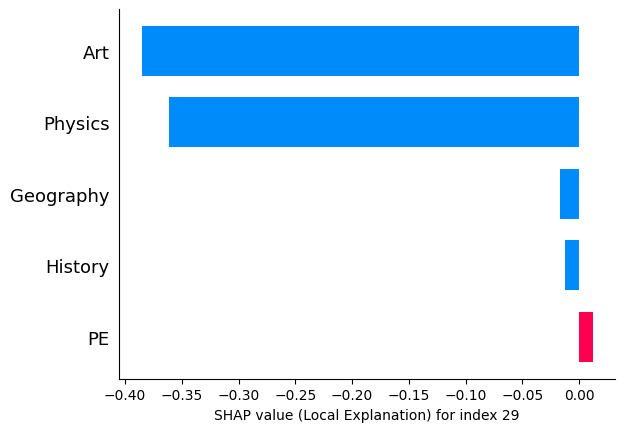

In [33]:
from src.utils.visualisation.deterministic_values import local_bar_plot, global_bar_plot
local_bar_plot(shapley_values, 29, feature_names=subjects)

/tmp/ipykernel_70553/3170391189.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mean_abs_shap_values = np.abs(shapley_values.T).mean(axis=0)


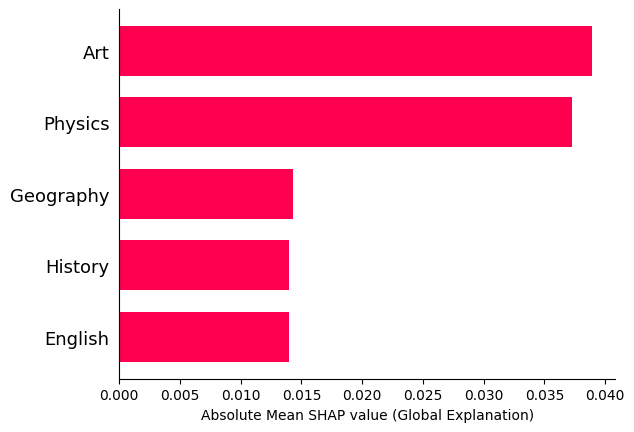

In [34]:
# global importance measure
mean_abs_shap_values = np.abs(shapley_values.T).mean(axis=0)  

# Call bar_plot for global explanation
global_bar_plot(mean_abs_shap_values, feature_names=subjects)